# Constants
Set these to make things run faster. In order to use the maximize these constants, just set them to `None`.

In [1]:
NUM_CASES    = 300  # Number of cases (spacys tokenization is quite slow)

NUM_FEATURES = 800  # Number of features (most common NGrams) for ML Tasks
TEST_RATIO = .1 # Test ratio for Machine Learning tasks

RANDOM_SEED = 0 # We choose the same random seed every time so we can preload pickeled cases

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Preparation

Load data from zipfile

In [2]:
import os
import numpy as np
from zipfile import ZipFile

cnt = 1
last_action = ""
def counter_message(max_cnt, action):
    """Displays Progress
    """
    global cnt, last_action
    
    #Reset Counter for every new action
    if last_action != action:
        cnt = 1
        last_action = action
    
    #Print Message
    print("\r{}/{}: {}.".format(cnt, max_cnt, action), end=" "*10, flush=True)
    cnt += 1

zfile = ZipFile("data/cases.zip")
caseids = []
raw_texts = {}
years = {}


# Randomly shuffle files and choose as many as we need 
members = zfile.namelist()
if NUM_CASES is None:
    NUM_CASES = len(members)
    
np.random.seed(RANDOM_SEED)
processed_files = np.random.permutation(members)[:NUM_CASES]

for case in processed_files:
    year, caseid = case[6:-4].split("_")
    with zfile.open(case) as f:
        raw_text = f.read().decode()
    raw_texts[caseid] = raw_text
    years[caseid] = int(year)
    caseids.append(caseid)
    counter_message(NUM_CASES, "opened")



300/300: opened.                                                            

Create and pickle `spacy` documents. If they have already been pickled, they're just loaded from memory.
Spacy running on a jupyter notebook ist the worst and slowest thing ever. Countless times my Kernel has "died" on my while just trying to create spacy documents of only 300 Documents. I have an average laptop and use it for coding and machine learning alot but somehow it can't handle processing some text files? This is really annoying and took a lot of my motivation for this homework. I tried pickeling them but that was not much faster either apart from filling my ssd with gigabytes of spacy documents.

In [3]:
import spacy
import pickle 
nlp = spacy.load('en') # requires:python -m spacy download en

spacy_documents = {}
for caseid in caseids:
    spacy_documents[caseid] = nlp(raw_texts[caseid])
    counter_message(NUM_CASES, "Created Spacy Document")


300/300: Created Spacy Document.          

Lemmatize corpus. We get rid of all whitespace and punctuation in order to just extract the relevant information. We use `spacy` to lemmatize the text (just base form of all words) and then remove any punctuation.

In [4]:
from nltk import ngrams
import string

def normalize(token):
    """Normalize Token. Get Lemma (base form) and remove any punctuation
    """
    lemma = token.lemma_
    nopunct = lemma.translate(str.maketrans('', '', string.punctuation))
    return nopunct

noun_ngrams = {}
total_ngrams = []
word_counts= {}

# Lemmatize Cases
for caseid in caseids:
    tokens = []
    spacy_document = spacy_documents[caseid]
    for token in spacy_document:
        
        if not token.is_punct and not token.is_space: # Ignore spaces (newlines etc) and punctuation
            tokens.append(token)
            norm = normalize(token)
            
            if not norm in word_counts: # We've seen the word for the first time
                word_counts[norm] = 1
            else:                       # We already know this word
                word_counts[norm] += 1

    noun_ngram = []
    for ngram in ngrams(tokens, 3): # iterate over all 3-grams
        if ngram[2].pos_ == "NOUN": # check if last word is a noun
            curr_ngram = (normalize(ngram[0]),
                               normalize(ngram[1]),
                               normalize(ngram[2]))
            noun_ngram.append(curr_ngram)   # Stores 3-grams for this case
            total_ngrams.append(curr_ngram) # Stores 3-grams for all cases
    
    noun_ngrams[caseid] = noun_ngram
    counter_message(len(caseids), "lemmatized")


300/300: lemmatized.                                                           

First save all the outcomes into a dictionary and then create two numpy arrays X holding the features and y holding the outcome. At the end standardize X in order to have variance = 1 for every entry.

In [ ]:
import pandas as pd
from collections import Counter

# Load outcomes into dictionary
meta_reversed = {}
meta_log_cite = {}
meta_judge_id = {}

# Load Dataframe and fill nan with 0
metadata = pd.read_csv("data/case_metadata.csv").fillna(0)


for caseid, rev, judge_id, year, log_cite  in metadata.values:
    meta_reversed[caseid] = float(rev)
    meta_log_cite[caseid] = float(log_cite)
    meta_judge_id[caseid] = int(judge_id)
    counter_message(len(metadata.values), "read metadata csv")

X = []
y = {'reversed':[],
     'judge_id':[],
     'log_cites':[]}

# Get most common n_grams
most_common = Counter(total_ngrams).most_common(NUM_FEATURES)

for caseid in caseids:
    current_ngram = Counter(noun_ngrams[caseid])
    features = np.zeros(len(most_common))
    for i in range(len(most_common)):
        ngram = most_common[i][0]
        if ngram in current_ngram: # Only add most common 3-gram frequencies
            features[i] = current_ngram[ngram]
    X.append(features)
    
    y['reversed'].append(meta_reversed[caseid])
    y['log_cites'].append(meta_log_cite[caseid])
    y['judge_id'].append(meta_judge_id[caseid])
    
    counter_message(NUM_CASES, "created ML features")

# convert to numpy array
X = np.array(X)

# standardize; maintain sparsity by not taking out the mean
X = X / np.std(X, axis=0)

for name, values in y.items():
    y[name] =  np.array(values)


1244/5762: read metadata csv.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Build and train Model

In [34]:
import numpy as np

# Shuffle Dataset
permutation = np.random.permutation(X.shape[0])
X = X[permutation]
for name, data in y.items():
    y[name] = y[name][permutation]

# Split into test & train dataset

test_amount = int(X.shape[0]*TEST_RATIO)

test_X = X[:test_amount]
train_X = X[test_amount:]

test_y = {}
train_y = {}
for name, data in y.items():
    test_y[name] = y[name][:test_amount]
    train_y[name] = y[name][test_amount:]

# Exercise 1

## Confusion Matrix

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Fit Logistic Regression Model with best performing parameters from last exercise
clf = LogisticRegression(penalty='l2',C=1).fit(train_X, train_y["reversed"])

y_pred = cross_val_predict(clf, test_X, test_y["reversed"])

conf = confusion_matrix(test_y["reversed"], y_pred)
print(conf)

print("true negatives:  {:^3}".format(conf[0][0]))
print("false negatives: {:^3}".format(conf[0][1]))
print("false positives: {:^3}".format(conf[1][0]))
print("true positives:  {:^3}".format(conf[1][1]))

[[ 4 11]
 [ 8  7]]
true negatives:   4 
false negatives: 11 
false positives:  8 
true positives:   7 


## Precision-Recall curve
My results don't seem right. I think the problem lies within the limited number of test cases, but as described above, I could not find a way to get more data without crashing the jupyter notebook by filling up my Memory with spacy documents.

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.45')

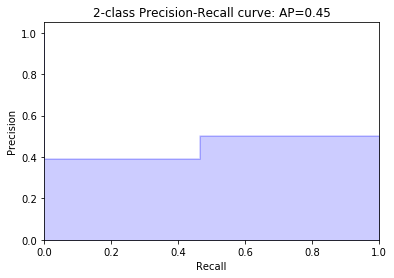

In [36]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.utils.fixes import signature
from matplotlib import pyplot as plt

average_precision = average_precision_score(test_y["reversed"], y_pred)

precision, recall, thresholds = precision_recall_curve(test_y["reversed"], y_pred)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')

plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

Text(0.5, 1.0, 'Roc Curve')

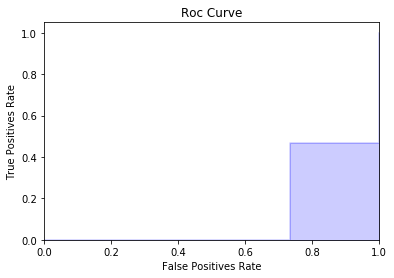

In [37]:
from sklearn.metrics import confusion_matrix, roc_curve

fpr, tpr, thresholds = roc_curve(test_y["reversed"], y_pred)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.step(fpr, tpr, color='b', alpha=0.2,
         where='post')

plt.fill_between(fpr, tpr, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Roc Curve')

# Exercise 2

The scaling with remained spasity has already been done in the preparation.

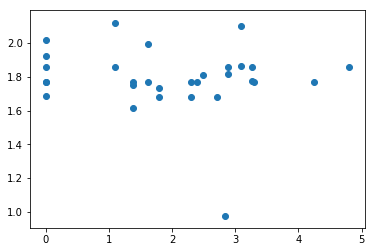

In [38]:
from sklearn.linear_model import ElasticNet

ela = ElasticNet().fit(train_X, train_y["log_cites"])
y_pred = cross_val_predict(ela, test_X, test_y["log_cites"], cv = 3)

plt.scatter(test_y["log_cites"], y_pred)

# Exercise 3

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

judge_cites = {}
for case_id, judge_id in  meta_judge_id.items():
    if judge_id not in judge_cites:
        judge_cites[judge_id] = []
    judge_cites[judge_id].append(meta_log_cite[case_id])

average_judge_cites = {}
for judge_id, cites in judge_cites.items():
    average_judge_cites[judge_id] = sum(cites) / len(cites)
    
Z = []
for judge_id in y['judge_id']:
    Z.append(average_judge_cites[judge_id])

Z = np.array(Z).reshape(-1,1)
test_Z = Z[:test_amount]
train_Z = Z[test_amount:]

z2x_reg = LinearRegression().fit(train_Z.reshape(-1,1), train_y['log_cites'])
x2y_reg  = LogisticRegression().fit(train_y['log_cites'].reshape(-1,1), train_y['reversed'])


X_pred = z2x_reg.predict(test_Z)
Y_pred1 = x2y_reg.predict(X_pred.reshape(-1,1))
Y_pred2 = x2y_reg.predict(test_y['log_cites'].reshape(-1,1))


accuracy1 = accuracy_score(Y_pred1, test_y["reversed"])
accuracy2 = accuracy_score(Y_pred2, test_y["reversed"])

print("Accuracy:")
print("Logistic Regression on Xpred: {}".format(accuracy1))
print("Logistic Regression on X:     {}".format(accuracy2))

Accuracy:
Logistic Regression on Xpred: 0.5
Logistic Regression on X:     0.5


# Exercise 4
Draws word clouds for topics. About 5 topics seemed right for me though this is highly subjective.

300/300: Extracting Words.                                                                                                                                                                                                                                                                                                                                         

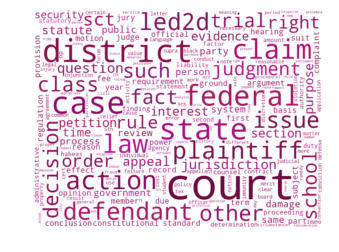

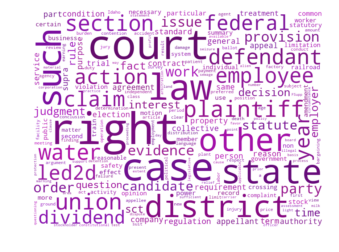

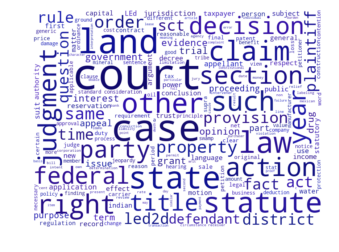

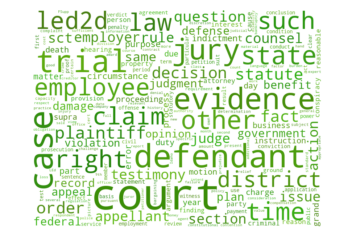

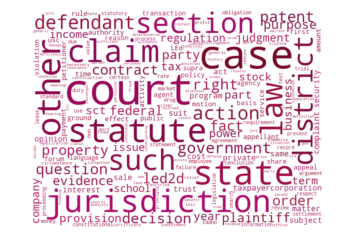

In [40]:
from gensim.models.ldamodel import LdaModel
from wordcloud import WordCloud
from random import randint

from gensim import corpora

from gensim.test.utils import common_texts

texts = []

for caseid, spacy_document in spacy_documents.items():
    texts.append([])
    for token in spacy_document:
        if token.pos_ in ["NOUN","ADJ"]: # Only look at nouns and adjectives
            texts[-1].append(normalize(token))
    counter_message(len(spacy_documents),"Extracting Words")
    
dictionary = corpora.Dictionary(texts)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in texts]

lda = LdaModel(doc_term_matrix, num_topics=5, 
               id2word = dictionary, passes=3)
# make word clouds for the topics
for i,weights in lda.show_topics(num_topics=-1,
                                 num_words=1000,
                                 formatted=False):
    
    #logweights = [w[0], np.log(w[1]) for w in weights]
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Exercise 5
Using tensorflow for logistic regression

In [41]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

input_dim = train_X.shape[1]

# define a model
x = Input((input_dim,), name="input_layer")
y = Dense(1, activation="softmax", name="output_layer")(x)
model1 = Model(x, y)  # compile the hypothesis function

# print model summary
model1.summary()

model1.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=['accuracy'])

history1 = model1.fit(x=train_X, y=train_y["reversed"],
          batch_size=64, epochs=10, verbose = 2,
          validation_data=(test_X, test_y["reversed"]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 800)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 801       
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Train on 270 samples, validate on 30 samples
Epoch 1/10
 - 0s - loss: 5.7865 - acc: 0.6370 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/10
 - 0s - loss: 5.7865 - acc: 0.6370 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/10
 - 0s - loss: 5.7865 - acc: 0.6370 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/10
 - 0s - loss: 5.7865 - acc: 0.6370 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/10
 - 0s - loss: 5.7865 - acc: 0.6370 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 6/10
 - 0s - loss: 5.7865 - acc: 0.6370 - val_loss: 7.9712 - val_acc: 0.50

In [42]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

input_dim = train_X.shape[1]

# define a model
x = Input((input_dim,), name="input_layer")
y = Dense(500, activation="relu", name="linear_layer1")(x)
y = Dropout(.2)(y)
y = Dense(500, activation="relu", name="linear_layer2")(y)
y = Dropout(.1)(y)
y = Dense(1, activation="softmax", name="output_layer")(y)
model2 = Model(x, y)  # compile the hypothesis function

# print model summary
model2.summary()

model2.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=['accuracy'])

history2 = model2.fit(x=train_X, y=train_y["reversed"],
          batch_size=64, epochs=30, verbose = 2,
          validation_data=(test_X, test_y["reversed"]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 800)               0         
_________________________________________________________________
linear_layer1 (Dense)        (None, 500)               400500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
linear_layer2 (Dense)        (None, 500)               250500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 501       
Total params: 651,501
Trainable params: 651,501
Non-trainable params: 0
_________________________________________________________________
Trai

Compare Models

In [43]:
from sklearn.metrics import accuracy_score, f1_score

pred0 = clf.predict(test_X)

accuracy0 = accuracy_score(pred0, test_y["reversed"])
accuracy1 = history1.history['val_acc'][-1] # We can actually get the validation accuracy from the keras history 
accuracy2 = history2.history['val_acc'][-1]

print(accuracy1, accuracy2)

print("Accuracy:")
print("Logistic regression Model: {:.2f}".format(accuracy0))
print("Keras1:                    {:.2f}".format(accuracy1))
print("Keras2:                    {:.2f}".format(accuracy2))


0.5 0.5
Accuracy:
Logistic regression Model: 0.40
Keras1:                    0.50
Keras2:                    0.50


Apparently it did not matter whether I used just a linear Model or a Model with Dropouts and more hidden layers, Both Keras models converged on the same accuracy of 50%